
# Assignment 2: Transformer Summarizer

Welcome to the second assignment of course 4. In this assignment you will explore summarization using the transformer model. **Unlike the lecture, you will be implementing an encoder-decoder model. However, don't worry; you will be guided through all the steps, and you will find numerous hints to assist you!**

There are many hints in this notebook so feel free to use them as needed. Actually by the end of this notebook you will have implemented the full transformer (both encoder and decoder) but you will only be graded on the implementation of the decoder as the encoder is provided for you.


In [8]:
import torch
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

torch.set_default_device(device)  # Set default device to GPU

Using device: cuda


In [1]:
# import sys
# !{sys.executable} -m pip install -U torchtext torch==2.3.0

## Table of Contents

- [Introduction](#0)
- [1 - Importing the Dataset](#1)
- [2 - Preprocess the Data](#2)
- [3 - Positional Encoding](#3)
- [4 - Masking](#4)
- [5 - Self-attention](#5)
    - [Exercise 1 - scaled_dot_product_attention](#ex-1)
- [6 - Encoder](#6)
    - [6.1 - Encoder Layer](#6-1)
    - [6.2 - Full Encoder](#6-2)
- [7 - Decoder](#7)
    - [7.1 - Decoder Layer](#7-1)
    - [Exercise 2 - DecoderLayer](#ex-2)
    - [7.2 - Full Decoder](#7-2)
    - [Exercise 3 - Decoder](#ex-3)
- [8 - Transformer](#8)
    - [Exercise 4 - Transformer](#ex-4)
- [9 - Initialize the Model](#9)
- [10 - Prepare for Training the Model](#10)
- [11 - Summarization](#11)
    - [Exercise 5 - next_word](#ex-5)
- [12 - Train the Model](#12)
- [13 - Summarize some sentences!](#13)


<a name='0'></a>
## Introduction

Summarization is an important task in natural language processing and could be useful for a consumer enterprise. For example, bots can be used to scrape articles, summarize them, and then you can use sentiment analysis to identify the sentiment about certain stocks. Who wants to read an article or a long email today anyway, when you can build a transformer to summarize text for you? Let's get started. By completing this assignment you will learn to:  

- Use built-in functions to preprocess your data
- Implement DotProductAttention
- Implement Causal Attention
- Understand how attention works
- Build the transformer model
- Evaluate your model
- Summarize an article

As you can tell, this model is slightly different than the ones you have already implemented. This is heavily based on attention and does not rely on sequences, which allows for parallel computing. 

In [2]:
import os

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import time
import utils

import textwrap
wrapper = textwrap.TextWrapper(width=70)

In [3]:
import w2_unittest_pytorch

ModuleNotFoundError: No module named 'dlai_grader'

<a name='1'></a>
## 1 - Import the Dataset
You have the dataset saved in a .json file, which you can easily open with pandas. The loading function has already been taken care of in `utils.py`.

In [9]:
data_dir = "data/corpus"

train_data, test_data = utils.get_train_test_data(data_dir)

# Take one example from the dataset and print it
example_summary, example_dialogue = train_data.iloc[10]
print(f"Dialogue:\n{example_dialogue}")
print(f"\nSummary:\n{example_summary}")

Dialogue:
Lucas: Hey! How was your day?
Demi: Hey there! 
Demi: It was pretty fine, actually, thank you!
Demi: I just got promoted! :D
Lucas: Whoa! Great news!
Lucas: Congratulations!
Lucas: Such a success has to be celebrated.
Demi: I agree! :D
Demi: Tonight at Death & Co.?
Lucas: Sure!
Lucas: See you there at 10pm?
Demi: Yeah! See you there! :D

Summary:
Demi got promoted. She will celebrate that with Lucas at Death & Co at 10 pm.


<a name='2'></a>
## 2 - Preprocess the data

First you will do some preprocessing of the data and split it into inputs and outputs. Here you also remove some of the characters that are specific to this dataset and add the `[EOS]` (end of sentence) token to the end, like it was discussed in the lecture videos. You will also add a `[SOS]` (start of sentence) token to the beginning of the sentences.

In [10]:
document, summary = utils.preprocess(train_data)
document_test, summary_test = utils.preprocess(test_data)

Now perform the standard preprocessing with the tensorflow library. You will need to modify the filters, because you dont want the `[EOS]` tokens to be removed.

Then create the vocabulary by combining the data in the documents and the summaries and using `.fit_on_texts()`:

In [11]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd

# Get the basic English tokenizer
basic_tokenizer = get_tokenizer("basic_english")

# Custom tokenizer function
def custom_tokenizer(text):
    filters = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n'
    return [token for token in text.split() if token not in filters]

# Wrapper for the basic English tokenizer that preserves case for special tokens
def case_preserving_tokenizer(text):
    special_tokens = ['[EOS]', '[SOS]', '[PAD]', '[UNK]']
    tokens = basic_tokenizer(text)
    result = []
    for token in tokens:
        if token.upper() in special_tokens:
            result.append(token.upper())
        else:
            result.append(token)

    return result  #[token if token.upper() in special_tokens else token.lower() for token in tokens]

# Combined tokenizer function
def combined_tokenizer(text):
    # First, apply the case-preserving basic English tokenizer
    tokens = case_preserving_tokenizer(text)
    
    # Then apply the custom tokenizer
    tokens = custom_tokenizer(' '.join(tokens))
    
    return tokens

# Create a tokenizer
# tokenizer = get_tokenizer(combined_tokenizer)

# Combine document and summary
documents_and_summary = document + summary

# Build vocabulary
def yield_tokens(data_iter):
    for text in data_iter:
        yield combined_tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(documents_and_summary), specials=['[UNK]', '[PAD]', '[SOS]', '[EOS]'])
vocab.set_default_index(vocab['[UNK]'])

# Tokenize inputs and targets
def tokenize_and_numericalize(text):
    return [vocab[token] for token in combined_tokenizer(text)]

inputs = [tokenize_and_numericalize(doc) for doc in document]
targets = [tokenize_and_numericalize(summ) for summ in summary]

vocab_size = len(vocab)

print(f'Size of vocabulary: {vocab_size}')


Size of vocabulary: 33746


Now you can pad the tokenized sequences for the training data.

For the purpose of this notebook you need to limit the length of the sequences, as transformers are really big models and are not meant to be trained in such small environments.

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
g = torch.Generator(device=device)

# Limit the size of the input and output data for being able to run it in this environment.
encoder_maxlen = 150
decoder_maxlen = 50

# Pad the sequences.
def pad_sequences(sequences, maxlen, padding='post', truncating='post'):
    padded_seqs = []
    for seq in sequences:
        if len(seq) > maxlen:
            if truncating == 'pre':
                seq = seq[-maxlen:]
            else:  # 'post'
                seq = seq[:maxlen]
        else:
            pad_length = maxlen - len(seq)
            if padding == 'pre':
                seq = [0] * pad_length + seq
            else:  # 'post'
                seq = seq + [0] * pad_length
        padded_seqs.append(seq)
    return np.array(padded_seqs)

inputs = pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

# Convert to PyTorch tensors
inputs = torch.tensor(inputs, dtype=torch.int32)
targets = torch.tensor(targets, dtype=torch.int32)

# Create the final training dataset.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Create TensorDataset
dataset = TensorDataset(inputs, targets)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)


cuda


<a name='3'></a>
## 3 - Positional Encoding

In sequence to sequence tasks, the relative order of your data is extremely important to its meaning. When you were training sequential neural networks such as RNNs, you fed your inputs into the network in order. Information about the order of your data was automatically fed into your model. However, when you train a Transformer network using multi-head attention, you feed your data into the model all at once. While this dramatically reduces training time, there is no information about the order of your data. This is where positional encoding is useful.

You have learned how to implement the positional encoding in one of this week's labs. Here you will use the `positional_encoding` function to create positional encodings for your transformer. The function is already implemented for you.

In [13]:
def positional_encoding(positions, d_model):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int): Maximum number of positions to be encoded 
        d_model (int): Encoding size 
    
    Returns:
        pos_encoding (tf.Tensor): A matrix of shape (1, position, d_model) with the positional encodings
    """
    
    position = np.arange(positions)[:, np.newaxis]
    k = np.arange(d_model)[np.newaxis, :]
    i = k // 2
    
    # initialize a matrix angle_rads of all the angles 
    angle_rates = 1 / np.power(10000, (2 * i) / np.float32(d_model))
    angle_rads = position * angle_rates
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return torch.tensor(pos_encoding, dtype=torch.float32)

<a name='4'></a>
## 4 - Masking

There are two types of masks that are useful when building your Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in your input sentence. 

You have already learned how to implement and use them in one of this week's labs. Here they are implemented for you.

In [14]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        decoder_token_ids (tensor): tensor of size (n, m)
    
    Returns:
        mask (torch.Tensor): binary tensor of size (n, 1, m)
    """

    if torch.is_tensor(decoder_token_ids):
        seq = 1 - (decoder_token_ids == 0).to(torch.float)

    elif isinstance(decoder_token_ids, np.ndarray):
        
        seq = 1 - (decoder_token_ids == 0)

    else:
        seq = torch.logical_not(decoder_token_ids == 0)
    
    # add extra dimensions to add the padding to the attention logits. 
    # this will allow for broadcasting later when comparing sequences

    if torch.is_tensor(seq):
        return seq
    else:
        return torch.from_numpy(seq).to(torch.float32)


def create_look_ahead_mask(batch_size, nhead, sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    
    Arguments:
        sequence_length (int): matrix size
    
    Returns:
        mask (torch.Tensor): binary tensor of size (sequence_length, sequence_length)
    """
    mask = torch.tril(torch.ones(batch_size*nhead, sequence_length, sequence_length), diagonal=0)
    return mask


<a name='5'></a>
## 5 - Self-Attention

As the authors of the Transformers paper state, "Attention is All You Need". 

<img src="images/self-attention.png" alt="Encoder" width="600"/>
<caption><center><font color='purple'><b>Figure 1: Self-Attention calculation visualization</font></center></caption>
    
The use of self-attention paired with traditional convolutional networks allows for parallelization which speeds up training. You will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to return rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

<a name='ex-1'></a>
### Exercise 1 - scaled_dot_product_attention 

Implement the function `scaled_dot_product_attention()` to create attention-based representations.

**Reminder**: The boolean mask parameter can be passed in as `none` or as either padding or look-ahead. 
    
* Multiply (1. - mask) by -1e9 before adding it to the scaled attention logits. 

**Additional Hints**
* You may find [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul) useful for matrix multiplication (check how you can use the parameter transpose_b).
* You can use [tf.keras.activations.softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) for softmax.

In [15]:
# GRADED FUNCTION: scaled_dot_product_attention
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q (tf.Tensor): query of shape (..., seq_len_q, depth)
        k (tf.Tensor): key of shape (..., seq_len_k, depth)
        v (tf.Tensor): value of shape (..., seq_len_v, depth_v)
        mask (tf.Tensor): mask with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    ### START CODE HERE ###
    
    # Multiply q and k transposed.
    matmul_qk = torch.linalg.matmul(q, k.T)

    # scale matmul_qk with the square root of dk
    dk = torch.tensor(k.shape[-1], dtype=torch.float32)
    scaled_attention_logits = matmul_qk / np.sqrt(dk)
    
    # add the mask to the scaled tensor.
    if mask is not None:  # Don't replace this None
        scaled_attention_logits = scaled_attention_logits.unsqueeze(0)
        scaled_attention_logits += (1. - mask) * -1e9 

    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = torch.nn.functional.softmax(scaled_attention_logits, dim=-1)
    
    # Multiply the attention weights by v
    output = torch.linalg.matmul(attention_weights, v)
    
    ### END CODE HERE ###

    return output, attention_weights\
    

In [16]:
# Test your function!
q_np = np.array([[1, 1, 0, 1], [0, 1, 1, 1], [1, 0, 1, 1]]).astype(np.float32)
k_np = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [1, 1, 1, 0], [0, 0, 0, 1], [0, 1, 0, 1]]).astype(np.float32)
v_np = np.array([[0, 0], [1, 0], [1, 0], [1, 1], [1, 1]]).astype(np.float32)

q = torch.from_numpy(q_np)
k = torch.from_numpy(k_np)
v = torch.from_numpy(v_np)

mask_np = np.array([[[0, 1, 0, 1, 1], [1, 0, 0, 1, 1], [1, 1, 0, 1, 1]]])
mask = torch.from_numpy(mask_np)

ou, atw = scaled_dot_product_attention(q, k, v, mask)
ou = np.around(ou, decimals=2)
atw = np.around(atw, decimals=2)

print(f"Output:\n {ou}")
print(f"\nAttention weigths:\n {atw}")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

##### __Expected Output__

```
Output:
 [[[1.   0.62]
  [0.62 0.62]
  [0.74 0.31]]]

Attention weigths:
 [[[0.   0.38 0.   0.23 0.38]
  [0.38 0.   0.   0.23 0.38]
  [0.26 0.43 0.   0.16 0.16]]]
```

Excellent work! You can now implement self-attention. With that, you can start building the encoder block! 

<a name='6'></a>
## 6 - Encoder

The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder, which you'll build later in the assignment. In this section of the assignment, you will implement the Encoder by pairing multi-head attention and a feed forward neural network (Figure 2a). 
<img src="images/encoder_layer.png" alt="Encoder" width="400"/>
<caption><center><font color='purple'><b>Figure 2a: Transformer encoder layer</font></center></caption>

* `MultiHeadAttention` you can think of as computing the self-attention several times to detect different features. 
* Feed forward neural network contains two Dense layers which we'll implement as the function `FullyConnected`

Your input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.
   
* For the `MultiHeadAttention` layer, you will use the [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) implemented in Keras. If you're curious about how to split the query matrix Q, key matrix K, and value matrix V into different heads, you can look through the implementation. 
* You will also use the [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) with two dense layers to built the feed forward neural network layers.

In [17]:
import torch.nn as nn

class FullyConnected(nn.Module):
    """
    Returns a sequential model consisting of two dense layers. The first dense layer has
    fully_connected_dim neurons and is activated by relu. The second dense layer has
    embedding_dim and no activation.

    Arguments:
        embedding_dim (int): output dimension
        fully_connected_dim (int): dimension of the hidden layer

    Returns:
        An instance of nn.Module that can be used as a feed-forward network in a larger model.ß
    """

    def __init__(self, embedding_dim, fully_connected_dim):
        super(FullyConnected, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, fully_connected_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fully_connected_dim, embedding_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


<a name='6-1'></a>
### 6.1 Encoder Layer

Now you can pair multi-head attention and feed forward neural network together in an encoder layer! You will also use residual connections and layer normalization to help speed up training (Figure 2a).

The encoder block (Figure 2) is is already implemented for you. Take a very close look at its implementation, as you will later have to create the decoder yourself, and a lot of the code is very similar. The encoder block performs the following steps: 
1. It takes the Q, V, K matrices and a boolean mask to a multi-head attention layer. Remember that to compute *self*-attention Q, V and K are the same. You will also perform Dropout in this multi-head attention layer during training. 
2. There is a skip connection to add your original input `x` and the output of the multi-head attention layer. 
3. After adding the skip connection, the output passes through the first normalization layer.
4. Finally, steps 1-3 are repeated but with the feed forward neural network with a dropout layer instead of the multi-head attention layer. 

<details>
  <summary><font size="2" color="darkgreen"><b>Additional Information (Click to expand)</b></font></summary>
    
* The `__init__` method creates all the layers that will be accesed by the the `call` method. Wherever you want to use a layer defined inside  the `__init__`  method you will have to use the syntax `self.[insert layer name]`. 
* You will find the documentation of [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) helpful. *Note that if query, key and value are the same, then this function performs self-attention.*
* The call arguments for `self.mha` are (Where B is for batch_size, T is for target sequence shapes, and S is output_shape):
 - `query`: Query Tensor of shape (B, T, dim).
 - `value`: Value Tensor of shape (B, S, dim).
 - `key`: Optional key Tensor of shape (B, S, dim). If not given, will use the same value for both key and value, which is the most common case.
 - `attention_mask`: a boolean mask of shape (B, T, S), that prevents attention to certain positions. The boolean mask specifies which query elements can attend to which key elements, 1 indicates attention and 0 indicates no attention. Broadcasting can happen for the missing batch dimensions and the head dimension.
 - `return_attention_scores`: A boolean to indicate whether the output should be attention output if True, or (attention_output, attention_scores) if False. Defaults to False.
 - `training`: Python boolean indicating whether the layer should behave in training mode (adding dropout) or in inference mode (no dropout). Defaults to either using the training mode of the parent layer/model, or False (inference) if there is no parent layer. Take a look at [tf.keras.layers.Dropout](https://www.tensorflow.org/versions/r2.4/api_docs/python/tf/keras/layers/Dropout) for more details (Additional reading in [Keras FAQ](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute))

In [18]:
class EncoderLayer(nn.Module):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This architecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        
        super(EncoderLayer, self).__init__()

        self.mha = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = nn.LayerNorm(embedding_dim, eps=layernorm_eps)
        self.layernorm2 = nn.LayerNorm(embedding_dim, eps=layernorm_eps)

        self.dropout_ffn = nn.Dropout(dropout_rate)
    
    def forward(self, x, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            encoder_layer_out (tf.Tensor): Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # calculate self-attention using mha(~1 line).
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training
        self_mha_output, _ = self.mha(x, x, x, key_padding_mask=mask, need_weights=False)  # Self attention (batch_size, input_seq_len, fully_connected_dim)

        # skip connection
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer
        skip_x_attention = self.layernorm1(x + self_mha_output)  # (batch_size, input_seq_len, fully_connected_dim)

        # pass the output of the multi-head attention layer through a ffn
        ffn_output = self.ffn(skip_x_attention)  # (batch_size, input_seq_len, fully_connected_dim)
        
        # apply dropout layer to ffn output during training
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output)
        
        # apply layer normalization on sum of the output from multi-head attention (skip connection) and ffn output
        # to get the output of the encoder layer
        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)  # (batch_size, input_seq_len, embedding_dim)
        
        return encoder_layer_out
    

<a name='6-2'></a>
### 6.2 - Full Encoder

Now you're ready to build the full Transformer Encoder (Figure 2b), where you will embed your input and add the positional encodings you calculated. You will then feed your encoded embeddings to a stack of Encoder layers. 

<img src="images/encoder.png" alt="Encoder" width="330"/>
<caption><center><font color='purple'><b>Figure 2b: Transformer Encoder</font></center></caption>

The Encoder class is implemented for you. It performs the following steps: 
1. Pass the input through the Embedding layer.
2. Scale the embedding by multiplying it by the square root of the embedding dimension. 
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to the embedding.
4. Pass the encoded embedding through a dropout layer
5. Pass the output of the dropout layer through the stack of encoding layers using a for loop.

In [19]:
class Encoder(nn.Module):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """  
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len)
            mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input

        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding dim)
        """
        seq_len = x.shape[1]
        
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= torch.sqrt(torch.tensor(self.embedding_dim, dtype=torch.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        # use `training=training`
        x = self.dropout(x)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, embedding_dim)

In [17]:
# Test your function!
n_layers = 5
emb_d = 13
n_heads = 13
kdim = 9
vdim = kdim
fully_connected_dim = 16
target_vocab_size = 300
maximum_position_encoding = 7

# encoder_test_output = torch.from_numpy(np.random.rand(3, 7, kdim)).to(torch.float32)
encoder_test = Encoder(n_layers, emb_d, n_heads, fully_connected_dim, target_vocab_size, maximum_position_encoding)

x_ = np.array([[2, 3, 1, 3, 0, 0, 0]])

mask = create_padding_mask(x_)

x = torch.from_numpy(x_).to(torch.int)

outd = encoder_test(x, mask.to(torch.float32))

print(f"Using num_layers={n_layers}, embedding_dim={emb_d} and num_heads={n_heads}:\n")
print(f"x has shape:{x.shape}")
print(f"Output of decoder has shape:{outd.shape}\n")


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

<a name='7'></a>
## 7 - Decoder

Now it is time to implement the decoder. You have seen it in the videos and you can use some help by looking at the encoder implementation above. The Decoder layer takes the K and V matrices generated by the Encoder and computes the second multi-head attention layer with the Q matrix from the output (Figure 3a).

<img src="images/decoder_layer.png" alt="Decoder" width="250"/>
<caption><center><font color='purple'><b>Figure 3a: Transformer Decoder layer</font></center></caption>

<a name='7-1'></a>    
### 7.1 - Decoder Layer
Again, you'll pair multi-head attention with a feed forward neural network, but this time you'll implement two multi-head attention layers. You will also use residual connections and layer normalization to help speed up training (Figure 3a).

<a name='ex-2'></a>    
### Exercise 2 - DecoderLayer
    
Implement `DecoderLayer()` using the `call()` method
    
1. Block 1 is a multi-head attention layer with a residual connection, and look-ahead mask. Like in the `EncoderLayer`, Dropout is defined within the multi-head attention layer.
2. Block 2 will take into account the output of the Encoder, so the multi-head attention layer will receive K and V from the encoder, and Q from the Block 1. You will then apply a normalization layer and a residual connection, just like you did before with the `EncoderLayer`.
3. Finally, Block 3 is a feed forward neural network with dropout and normalization layers and a residual connection.
    
**Additional Hints:**
* The first two blocks are fairly similar to the EncoderLayer except you will return `attention_scores` when computing self-attention

In [20]:
# GRADED FUNCTION: DecoderLayer
class DecoderLayer(nn.Module):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, kdim, vdim, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True
        )

        self.mha2 = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout_rate,
            kdim=kdim,
            vdim=vdim,
            batch_first=True
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = nn.LayerNorm(embedding_dim, eps=layernorm_eps)
        self.layernorm2 = nn.LayerNorm(embedding_dim, eps=layernorm_eps)
        self.layernorm3 = nn.LayerNorm(embedding_dim, eps=layernorm_eps)

        self.dropout_ffn = nn.Dropout(dropout_rate)
    
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output (tf.Tensor): Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            out3 (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attn_weights_block1 (tf.Tensor): Tensor of shape (batch_size, num_heads, target_seq_len, target_seq_len)
            attn_weights_block2 (tf.Tensor): Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """
        
        ### START CODE HERE ###
        # enc_output.shape == (batch_size, input_seq_len, fully_connected_dim)
        
        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training (~1 line).
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, attn_mask=look_ahead_mask, is_causal=True, need_weights=True, average_attn_weights=False,) 
        
        # apply layer normalization (layernorm1) to the sum of the attention output and the input (~1 line)
        Q1 = self.layernorm1(x + mult_attn_out1)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output. 
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2 (~1 line)

        mult_attn_out2, attn_weights_block2 = self.mha2(Q1, enc_output, enc_output, key_padding_mask=padding_mask, need_weights=True, average_attn_weights=False,)
        
        # # apply layer normalization (layernorm2) to the sum of the attention output and the Q from the first block (~1 line)
        mult_attn_out2 = self.layernorm2(Q1 + mult_attn_out2)
                
        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)
        
        # apply a dropout layer to the ffn output
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output)
        
        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 = self.layernorm3(ffn_output + mult_attn_out2)
        ### END CODE HERE ###

        return out3, attn_weights_block1, attn_weights_block2
    

In [17]:
# Test your function!
key_dim = 12
n_heads = 12
kdim = 8
vdim = 8

decoderLayer_test = DecoderLayer(embedding_dim=key_dim, kdim=kdim, vdim=vdim, num_heads=n_heads, fully_connected_dim=32)

q_np = np.ones((1, 15, key_dim))
q = torch.from_numpy(q_np).to(torch.float32)
encoder_test_output = torch.tensor(np.random.rand(1, 7, kdim)).to(torch.float32)
look_ahead_mask_ = create_look_ahead_mask(1, n_heads, q.shape[1])

look_ahead_mask = look_ahead_mask_.to(torch.float32)

print(f"Using embedding_dim={key_dim} and num_heads={n_heads}:\n")
print(f"q has shape:{q.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

out, attn_w_b1, attn_w_b2 = decoderLayer_test(q, encoder_test_output, look_ahead_mask, None)

print(f"Output of decoder layer has shape:{out.shape}")
print(f"Att Weights Block 1 has shape:{attn_w_b1.shape}")
print(f"Att Weights Block 2 has shape:{attn_w_b2.shape}")

Using embedding_dim=12 and num_heads=12:

q has shape:torch.Size([1, 15, 12])
Output of encoder has shape:torch.Size([1, 7, 8])

Output of decoder layer has shape:torch.Size([1, 15, 12])
Att Weights Block 1 has shape:torch.Size([1, 12, 15, 15])
Att Weights Block 2 has shape:torch.Size([1, 12, 15, 7])


##### __Expected Output__

```
Output:
Using embedding_dim=12 and num_heads=16:

q has shape:(1, 15, 12)
Output of encoder has shape:(1, 7, 8)

Output of decoder layer has shape:(1, 15, 12)
Att Weights Block 1 has shape:(1, 16, 15, 15)
Att Weights Block 2 has shape:(1, 16, 15, 7)
```

In [61]:
import w2_unittest_pytorch

In [ ]:
# UNIT TEST
w2_unittest_pytorch.test_decoderlayer(DecoderLayer, create_look_ahead_mask)

<a name='7-2'></a> 
### 7.2 - Full Decoder
You're almost there! Time to use your Decoder layer to build a full Transformer Decoder (Figure 3b). You will embed your output and add positional encodings. You will then feed your encoded embeddings to a stack of Decoder layers. 


<img src="images/decoder.png" alt="Decoder" width="300"/>
<caption><center><font color='purple'><b>Figure 3b: Transformer Decoder</font></center></caption>

<a name='ex-3'></a>     
### Exercise 3 - Decoder

Implement `Decoder()` using the `call()` method to embed your output, add positional encoding, and implement multiple decoder layers.
 
In this exercise, you will initialize your Decoder with an Embedding layer, positional encoding, and multiple DecoderLayers. Your `call()` method will perform the following steps: 
1. Pass your generated output through the Embedding layer.
2. Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type `tf.float32` before computing the square root.
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to your embedding.
4. Pass the encoded embedding through a dropout layer, remembering to use the `training` parameter to set the model training mode. 
5. Pass the output of the dropout layer through the stack of Decoding layers using a for loop.

In [21]:
# GRADED FUNCTION: Decoder
class Decoder(nn.Module):
    """
    The entire Encoder starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, kdim, vdim, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        kdim=kdim,
                                        vdim=vdim,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len)
            enc_output (tf.Tensor):  Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = x.shape[1]
        attention_weights = {}
        
        ### START CODE HERE ###
        # create word embeddings 
        x = self.embedding(x).to(torch.float32)
        
        # scale embeddings by multiplying by the square root of their dimension
        x *= torch.sqrt(torch.tensor(self.embedding_dim).to(torch.float32))
        
        # add positional encodings to word embedding
        x += self.pos_encoding[:, :seq_len, :]

        # apply a dropout layer to x
        # use `training=training`
        x = self.dropout(x)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        ### END CODE HERE ###
        
        # x.shape == (batch_size, target_seq_len, fully_connected_dim)
        return x, attention_weights

In [19]:
# Test your function!
n_layers = 5
emb_d = 13
n_heads = 13
kdim = 9
vdim = kdim
fully_connected_dim = 16
target_vocab_size = 300
maximum_position_encoding = 6

x_ = np.array([[3, 2, 1, 1], [2, 1, 1, 0], [2, 1, 1, 0]])
x = torch.from_numpy(x_).to(torch.int)

encoder_test_output = torch.from_numpy(np.random.rand(3, 7, kdim)).to(torch.float32)

look_ahead_mask = create_look_ahead_mask(x.shape[0], n_heads, x.shape[1])

decoder_test = Decoder(n_layers, emb_d, n_heads, kdim, vdim, fully_connected_dim, target_vocab_size,maximum_position_encoding)
                   
outd, att_weights = decoder_test(x, encoder_test_output, look_ahead_mask, None)

print(f"Using num_layers={n_layers}, embedding_dim={emb_d} and num_heads={n_heads}:\n")
print(f"x has shape:{x.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder has shape:{outd.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=5, embedding_dim=13 and num_heads=13:

x has shape:torch.Size([3, 4])
Output of encoder has shape:torch.Size([3, 7, 9])

Output of decoder has shape:torch.Size([3, 4, 13])

Attention weights:
decoder_layer1_block1_self_att has shape:torch.Size([3, 13, 4, 4])
decoder_layer1_block2_decenc_att has shape:torch.Size([3, 13, 4, 7])
decoder_layer2_block1_self_att has shape:torch.Size([3, 13, 4, 4])
decoder_layer2_block2_decenc_att has shape:torch.Size([3, 13, 4, 7])
decoder_layer3_block1_self_att has shape:torch.Size([3, 13, 4, 4])
decoder_layer3_block2_decenc_att has shape:torch.Size([3, 13, 4, 7])
decoder_layer4_block1_self_att has shape:torch.Size([3, 13, 4, 4])
decoder_layer4_block2_decenc_att has shape:torch.Size([3, 13, 4, 7])
decoder_layer5_block1_self_att has shape:torch.Size([3, 13, 4, 4])
decoder_layer5_block2_decenc_att has shape:torch.Size([3, 13, 4, 7])


##### __Expected Output__

```
Using num_layers=5, embedding_dim=13 and num_heads=17:

x has shape:(3, 4)
Output of encoder has shape:(3, 7, 9)

Output of decoder has shape:(3, 4, 13)

Attention weights:
decoder_layer1_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer1_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer2_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer2_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer3_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer3_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer4_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer4_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer5_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer5_block2_decenc_att has shape:(3, 17, 4, 7)
```

In [ ]:
# UNIT TEST
w2_unittest_pytorch.test_decoder(Decoder, create_look_ahead_mask, create_padding_mask)

<a name='8'></a> 
## 8 - Transformer

Phew! This has been quite the assignment! Congratulations! You've done all the hard work, now it's time to put it all together.  

<img src="images/transformer.png" alt="Transformer" width="550"/>
<caption><center><font color='purple'><b>Figure 4: Transformer</font></center></caption>
    
The flow of data through the Transformer Architecture is as follows:
* First your input passes through an Encoder, which is just repeated Encoder layers that you implemented:
    - embedding and positional encoding of your input
    - multi-head attention on your input
    - feed forward neural network to help detect features
* Then the predicted output passes through a Decoder, consisting of the decoder layers that you implemented:
    - embedding and positional encoding of the output
    - multi-head attention on your generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - a feed forward neural network to help detect features
* Finally, after the Nth Decoder layer, one dense layer and a softmax are applied to generate prediction for the next output in your sequence.

<a name='ex-4'></a> 
### Exercise 4 - Transformer

Implement `Transformer()` using the `call()` method
1. Pass the input through the Encoder with the appropiate mask.
2. Pass the encoder output and the target through the Decoder with the appropiate mask.
3. Apply a linear transformation and a softmax to get a prediction.

In [22]:
# GRADED FUNCTION: Transformer
class Transformer(nn.Module):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, kdim, vdim, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               kdim=kdim,
                               vdim=vdim,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)
        
        
        self.final_layer = nn.Linear(embedding_dim, target_vocab_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, input_sentence, output_sentence, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence (tf.Tensor): Tensor of shape (batch_size, input_seq_len)
                              An array of the indexes of the words in the input sentence
            output_sentence (tf.Tensor): Tensor of shape (batch_size, target_seq_len)
                              An array of the indexes of the words in the output sentence
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            dec_padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            final_output (tf.Tensor): The final output of the model
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        ### START CODE HERE ###
        # call self.encoder with the appropriate arguments to get the encoder output

        enc_output = self.encoder(input_sentence, enc_padding_mask)

        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, look_ahead_mask, dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax (~1 line)
        final_output = self.final_layer(dec_output)
        # final_output = self.softmax(final_output)
        ### END CODE HERE ###

        return final_output, attention_weights

In [18]:
# Test your function!
n_layers = 3
emb_d = 13
n_heads = 13
fully_connected_dim = 8
input_vocab_size = 300
target_vocab_size = 350
kdim = 13
vdim = kdim
max_positional_encoding_input = 12
max_positional_encoding_target = 12

transformer = Transformer(n_layers, emb_d, n_heads, kdim, vdim, fully_connected_dim, input_vocab_size, target_vocab_size, max_positional_encoding_input, max_positional_encoding_target)

# 0 is the padding value
sentence_a_ = np.array([[2, 3, 1, 3, 0, 0, 0]])
sentence_b_ = np.array([[2]])

sentence_a = torch.from_numpy(sentence_a_).to(torch.int)
sentence_b = torch.from_numpy(sentence_b_).to(torch.int)

enc_padding_mask = create_padding_mask(sentence_a_)
dec_padding_mask = create_padding_mask(sentence_a_)

look_ahead_mask = create_look_ahead_mask(1, n_heads, sentence_b.shape[1])

test_summary, att_weights = transformer(
    sentence_a,
    sentence_b,
    enc_padding_mask,
    look_ahead_mask,
    dec_padding_mask
)

print(f"Using num_layers={n_layers}, target_vocab_size={target_vocab_size} and num_heads={n_heads}:\n")
print(f"sentence_a has shape:{sentence_a.shape}")
print(f"sentence_b has shape:{sentence_b.shape}")
# print(f"test_summary: {test_summary}")

print(f"\nOutput of transformer (summary) has shape:{test_summary.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=3, target_vocab_size=350 and num_heads=13:

sentence_a has shape:torch.Size([1, 7])
sentence_b has shape:torch.Size([1, 1])

Output of transformer (summary) has shape:torch.Size([1, 1, 350])

Attention weights:
decoder_layer1_block1_self_att has shape:torch.Size([1, 13, 1, 1])
decoder_layer1_block2_decenc_att has shape:torch.Size([1, 13, 1, 7])
decoder_layer2_block1_self_att has shape:torch.Size([1, 13, 1, 1])
decoder_layer2_block2_decenc_att has shape:torch.Size([1, 13, 1, 7])
decoder_layer3_block1_self_att has shape:torch.Size([1, 13, 1, 1])
decoder_layer3_block2_decenc_att has shape:torch.Size([1, 13, 1, 7])


##### __Expected Output__

```
Using num_layers=3, target_vocab_size=350 and num_heads=17:

sentence_a has shape:(1, 7)
sentence_b has shape:(1, 7)

Output of transformer (summary) has shape:(1, 7, 350)

Attention weights:
decoder_layer1_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer1_block2_decenc_att has shape:(1, 17, 7, 7)
decoder_layer2_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer2_block2_decenc_att has shape:(1, 17, 7, 7)
decoder_layer3_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer3_block2_decenc_att has shape:(1, 17, 7, 7)
```

In [ ]:
# UNIT TEST
w2_unittest.test_transformer(Transformer, create_look_ahead_mask, create_padding_mask)

<a name='9'></a>
## 9 - Initialize the Model
Now that you have defined the model, you can initialize and train it. First you can initialize the model with the parameters below. Note that generally these models are much larger and you are using a smaller version to fit this environment and to be able to train it in just a few minutes.

The base model described in the original Transformer paper used `num_layers=6`, `embedding_dim=512`, and `fully_connected_dim=2048`.

In [23]:
# Define the model parameters
num_layers = 2
embedding_dim = 128
kdim = vdim = embedding_dim
fully_connected_dim = 128
num_heads = 2
positional_encoding_length = 256

# Initialize the model
transformer = Transformer(
    num_layers, 
    embedding_dim, 
    num_heads,
    kdim,
    vdim,
    fully_connected_dim,
    vocab_size, 
    vocab_size, 
    positional_encoding_length, 
    positional_encoding_length,
)

<a name='10'></a>
## 10 - Prepare for Training the Model

The original transformer paper uses Adam optimizer with custom learning rate scheduling, which we define in the cell below. This was empirically shown to produce faster convergence.

In [57]:
'''A wrapper class for scheduled optimizer '''
import numpy as np

class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr


optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = ScheduledOptim(optimizer, lr_mul=1, d_model=embedding_dim, n_warmup_steps=462)


In [36]:
import torch
from torch.optim.lr_scheduler import _LRScheduler
import math

class CustomSchedule(_LRScheduler):
    def __init__(self, optimizer, d_model, warmup_steps=2000, last_epoch=-1):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        super(CustomSchedule, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        step = max(1, self.last_epoch)  # To avoid division by zero
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        lr = (self.d_model ** -0.5) * min(arg1, arg2)
        return [lr for _ in self.base_lrs]

# Example usage
# embedding_dim = 512  # Set embedding_dim as needed
# model = torch.nn.Linear(embedding_dim, embedding_dim)  # Sample model

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9)
# scheduler = CustomSchedule(optimizer, d_model=embedding_dim)

# # Training loop example
# for epoch in range(1000):  # Replace 1000 with your desired number of steps
#     optimizer.step()
#     scheduler.step()
#     print(f"Learning Rate: {scheduler.get_lr()[0]}")


Below you can plot, how the custom learning rate looks like.

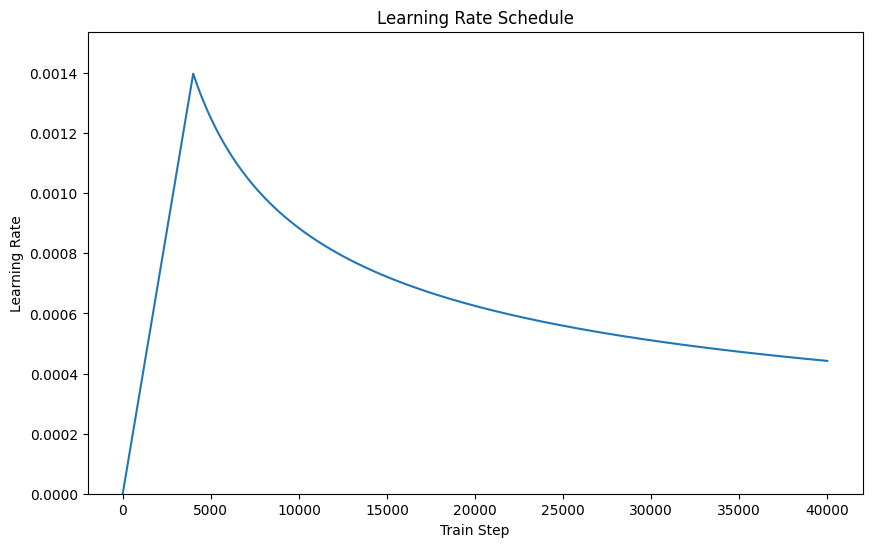

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lr_schedule(sched, num_steps=40000):
    lrs = []
    for step in range(1, num_steps + 1):
        sched.n_steps = step  # Manually update the step count
        lr = sched.lr_mul * sched._get_lr_scale()
        lrs.append(lr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_steps + 1), lrs)
    plt.xlabel('Train Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.ylim(0, max(lrs) * 1.1)  # Set y-axis limit to slightly above the max lr
    plt.show()

# Assuming you've already created your ScheduledOptim instance named 'sched'
plot_lr_schedule(scheduler)


Next, you set up the loss. Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

You will use the sparse categorical cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`) and set the parameter `from_logits` to False since the Transformer does not output raw logits since the last layer has a softmax activation:

In [25]:
# Define the loss function
loss_object = nn.CrossEntropyLoss(reduction='none')

def masked_loss(real, pred):
    # Create a mask where real != 0
    mask = (real != 0).float()
    
    # Compute the loss
    loss_ = loss_object(pred, real)
    print(loss_)
    # Apply the mask
    loss_ *= mask
    
    # Compute the mean loss over non-padded elements
    return loss_.sum() / mask.sum()

# Define a metric to track the average loss
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

train_loss = AverageMeter()

# List to store losses for plotting
losses = []


Now you can define your custom training function. If you are not very advanced with tensorflow, you can understand this function as an alternative to using `model.compile()` and `model.fit()`, but with added extra flexibility.

In [25]:
def train_step(transformer, inp, tar, optimizer, create_padding_mask, create_look_ahead_mask):
    """
    One training step for the transformer
    Arguments:
        model (nn.Module): The transformer model
        inp (torch.Tensor): Input data to summarize
        tar (torch.Tensor): Target (summary)
        optimizer (torch.optim.Optimizer): The optimizer
        criterion (nn.Module): The loss function
        create_padding_mask (function): Function to create padding mask
        create_look_ahead_mask (function): Function to create look-ahead mask
    Returns:
        float: The loss value
    """
    num_heads = 2
    transformer.train()
    optimizer.zero_grad()

    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    # Create masks
    enc_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tar_inp.shape[0], num_heads, tar_inp.size(1))
    dec_padding_mask = create_padding_mask(inp)  # Notice that both encoder and decoder padding masks are equal

    print(inp.shape)
    print(tar_real.shape)
    print(tar_inp.shape)

    predictions, _ = transformer(
        inp,
        tar_inp, 
        enc_padding_mask, 
        look_ahead_mask, 
        dec_padding_mask
    )
    print(predictions.shape)
    
    loss = masked_loss(predictions.reshape(-1, predictions.size(-1)), tar_real.reshape(-1))

    loss.backward()
    optimizer.step()

    return loss.item()

# Example usage in a training loop:
# for epoch in range(num_epochs):
#     for batch in dataloader:
#         inp, tar = batch
#         loss = train_step(model, inp, tar, optimizer, criterion, create_padding_mask, create_look_ahead_mask)
#         train_loss.update(loss)


Now you are ready for training the model. But before starting the training, you can also define one more set of functions to perform the inference. Because you are using a custom training loop, you can do whatever you want between the training steps. And wouldnt't it be fun to see after each epoch some examples of how the model performs?

<a name='11'></a>
## 11 - Summarization

The last thing you will implement is inference. With this, you will be able to produce actual summaries of the documents. You will use a simple method called greedy decoding, which means you will predict one word at a time and append it to the output. You will start with an `[SOS]` token and repeat the word by word inference until the model returns you the `[EOS]` token or until you reach the maximum length of the sentence (you need to add this limit, otherwise a poorly trained model could give you infinite sentences without ever producing the `[EOS]` token.

<a name='ex-5'></a> 
### Exercise 5 - next_word
Write a helper function that predicts the next word, so you can use it to write the whole sentences. Hint: this is very similar to what happens in the train_step, but you have to set the training of the model to False.

In [25]:
# GRADED FUNCTION: next_word
def next_word(transformer, encoder_input, output):
    """
    Helper function for summarization that uses the model to predict just the next word.
    Arguments:
        encoder_input (tf.Tensor): Input data to summarize
        output (tf.Tensor): (incomplete) target (summary)
    Returns:
        predicted_id (tf.Tensor): The id of the predicted word
    """
    ### START CODE HERE ###
    # Create a padding mask for the input (encoder)
    enc_padding_mask = create_padding_mask(encoder_input)
    # Create a look-ahead mask for the output
    look_ahead_mask = create_look_ahead_mask(encoder_input.shape[0], num_heads, output.shape[1])
    # Create a padding mask for the input (decoder)
    dec_padding_mask = create_padding_mask(encoder_input)

    # Run the prediction of the next word with the transformer model
    predictions, attention_weights = transformer(
        encoder_input,
        output,
        enc_padding_mask,
        look_ahead_mask,
        dec_padding_mask
    )
    ### END CODE HERE ###

    predictions = predictions[: ,-1:, :]
    predicted_id = torch.argmax(predictions, dim=-1)

    return predicted_id

In [26]:
def pad_sequence(sequence, max_length, padding_value=0):
    # Convert to tensor if it's a list
    if isinstance(sequence, list):
        sequence = torch.tensor(sequence)
    
    # If the sequence is 2D, take the first (and only) row
    if sequence.dim() == 2:
        sequence = sequence.squeeze(0)
    
    # Get the current sequence length
    current_length = sequence.size(0)
    
    # If the sequence is already longer than max_length, truncate it
    if current_length > max_length:
        return sequence[:max_length]
    
    # Calculate the amount of padding needed
    padding_length = max_length - current_length
    
    # Create a padding tensor
    padding = torch.full((padding_length,), padding_value, dtype=sequence.dtype)
    
    # Concatenate the original sequence with the padding
    padded_sequence = torch.cat([sequence, padding])
    
    return padded_sequence.to(torch.int32)


Check if your function works.

In [27]:
# Take a random sentence as an input
input_document = ["this is a very long sentence"]
input_document = [tokenize_and_numericalize(doc) for doc in input_document]
input_document = pad_sequence(input_document, encoder_maxlen, padding_value=0)
encoder_input = input_document.unsqueeze(dim=0)

# Take the start of sentence token as the only token in the output to predict the next word
output = torch.tensor([[vocab['[SOS]']]])

# Predict the next word with your function
predicted_token = next_word(transformer, encoder_input, output)
print(f"Predicted token: {predicted_token}")

predicted_word = vocab.lookup_tokens(predicted_token.tolist()[0])
print(f"Predicted word: {predicted_word}")


Predicted token: tensor([[27038]], device='cuda:0')
Predicted word: ['incorporates']


##### __Expected Output__

```
Predicted token: [[14859]]
Predicted word: masses
```

In [ ]:
# UNIT TEST
w2_unittest.test_next_word(next_word, transformer, encoder_input, output)

In [28]:
def summarize(model, input_document):
    """
    A function for summarization using the transformer model
    Arguments:
        input_document (tf.Tensor): Input data to summarize
    Returns:
        _ (str): The summary of the input_document
    """    
    input_document = [input_document]
    input_document = [tokenize_and_numericalize(doc) for doc in input_document]
    input_document = pad_sequence(input_document, encoder_maxlen, padding_value=0)
    encoder_input = input_document.unsqueeze(dim=0)
    
    output = torch.tensor([[vocab['[SOS]']]])

    for i in range(decoder_maxlen):
        predicted_id = next_word(model, encoder_input, output)
        output = torch.concat([output, predicted_id], axis=-1)
        
        if predicted_id.squeeze().item() == vocab['[EOS]']:
            break
        
    output = vocab.lookup_tokens(output.squeeze().tolist())

    return " ".join(output)

In [28]:
vocab["[SOS]"]

2

Now you can already summarize a sentence! But beware, since the model was not yet trained at all, it will just produce nonsense.

In [29]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
summarize(transformer, document[training_set_example])

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:


'[SOS] incorporates movers farty-poop heatwaves airbus dreadfully landmarks acro south weaknesses panini star-wars <link> laps gifted perfected boardgame forrest engelbert favorite frightfully washing-up jannet displays screenshot misunderstandings destroy oooookay seawater parents-in-law godsent achieving turandot condemn fidgety pseudo ellie-mae harmless lookk xiaomi d&d brags dereck comicon containers 15-25 swoop eglinton gimmick dollars'

<a name='12'></a>
# 12 - Train the model

Now you can finally train the model. Below is a loop that will train your model for 20 epochs. note that it should take about 30 seconds per epoch (with the exception of the first few epochs which can take a few minutes each).

Note that after each epoch you perform the summarization on one of the sentences in the test set and print it out, so you can see how your model is improving.

In [37]:
# Take an example from the test set, to monitor it during training
test_example = 0
true_summary = summary_test[test_example]
true_document = document_test[test_example]

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

torch.set_default_device(device)  # Set default device to GPU

In [38]:
# Check if MPS is available


num_epochs = 20
# learning_rate = 0.0001

# Define the model parameters
num_layers = 2
embedding_dim = 128
kdim = vdim = embedding_dim
fully_connected_dim = 128
num_heads = 2
positional_encoding_length = 256

# Initialize the model
transformer = Transformer(
    num_layers, 
    embedding_dim, 
    num_heads,
    kdim,
    vdim,
    fully_connected_dim,
    vocab_size, 
    vocab_size, 
    positional_encoding_length, 
    positional_encoding_length,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)  # Assuming 0 is the padding index
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9)
scheduler = CustomSchedule(optimizer, d_model=embedding_dim)

train_losses = []
epoch_losses = []

print_every = 60

# Before training loop
# for name, param in transformer.named_parameters():
#     print(f"{name}: requires_grad = {param.requires_grad}")

# Training loop
for epoch in range(num_epochs):
    
    transformer.train()
    total_loss = 0
    batch_count = 0
    start = time.time()
    
    for batch_idx, batch in enumerate(dataloader):
        src, tgt = batch
        src = src.to(device)
        tgt = tgt.to(device)
        
        # Prepare input and target sequences
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        
        # Create masks
        enc_padding_mask = create_padding_mask(src)
        enc_padding_mask = enc_padding_mask.to(device)
        look_ahead_mask = create_look_ahead_mask(tgt_input.shape[0], num_heads, tgt_input.size(1))
        look_ahead_mask = look_ahead_mask.to(device)
        dec_padding_mask = create_padding_mask(src)  # Notice that both encoder and decoder padding masks are equal
        dec_padding_mask = dec_padding_mask.to(device)

        # Forward pass
        optimizer.zero_grad()
        output, _ = transformer(src, tgt_input, enc_padding_mask, look_ahead_mask, dec_padding_mask)

        # # Check model output
        # print(f"Model output shape: {output.shape}")
        # print(f"Model output min: {output.min()}, max: {output.max()}, mean: {output.mean()}")

        # # Check target
        # print(f"Target shape: {tgt_output.shape}")
        # print(f"Target min: {tgt_output.min()}, max: {tgt_output.max()}")

        # output_id = torch.argmax(output, dim=-1)
        # Reshape output and target for loss computation
        output = output.reshape(-1, vocab_size)
        tgt_output = tgt_output.reshape(-1).to(torch.long)
        
        # Compute loss
        loss = criterion(output, tgt_output)

        # Check loss computation
        # print(f"Computed loss: {loss.item()}")
        
        # Backward pass and optimization
        loss.backward()

        # scheduler.step_and_update_lr()

        before_lr = optimizer.param_groups[0]["lr"]
        optimizer.step()
        scheduler.step()
        
        after_lr = optimizer.param_groups[0]["lr"]
        
        # # Inside training loop, after loss.backward()
        # print(f"Loss: {loss.item()}")
        # for name, param in transformer.named_parameters():
        #     if param.grad is None:
        #         print(f"No grad for {name}")
        #     elif param.grad.sum() == 0:
        #         print(f"Zero grad for {name}")
        #     else:
        #         print(f"Grad for {name}: min = {param.grad.min()}, max = {param.grad.max()}, mean = {param.grad.mean()}")

        total_loss += loss.item()
        # train_losses.append(loss.item())
        batch_count += 1

        train_losses.append(loss.item())

        # Print loss every N batches
        if (batch_idx + 1) % print_every == 0:
            print("batch_n %d: SGD lr %.4f -> %.4f" % (batch_count, before_lr, after_lr))
        #     avg_loss = total_loss / batch_count
        #     print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloader)}, Loss: {avg_loss:.4f}")
        #     total_loss = 0
        #     batch_count = 0

        # if batch_idx % 100 == 0:
        #     current_lr = scheduler._optimizer.param_groups[0]['lr']
        #     print(f'Train Step: {batch_idx}, Loss: {loss.item()}, Learning Rate: {current_lr}')

    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    print (f'Time taken for one epoch: {time.time() - start} sec')
    print('Example summarization on the test set:')
    print('  True summarization:')
    print(f'    {true_summary}')
    print('  Predicted summarization:')
    print(f'    {summarize(transformer, true_document)}\n')

batch_n 60: SGD lr 0.0001 -> 0.0001
batch_n 120: SGD lr 0.0001 -> 0.0001
batch_n 180: SGD lr 0.0002 -> 0.0002
Epoch 1/20, Average Loss: 10.2050
Time taken for one epoch: 8.374767065048218 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] holidays kurt prefer gus take plans trip leave but her south south suspicion stage take plans match millenials planning and is jessica people new doesn contact and dad conversation is helen will take stays ellie give do semester zack is solve from s day robyn political towel week diva 7

batch_n 60: SGD lr 0.0003 -> 0.0003
batch_n 120: SGD lr 0.0003 -> 0.0003
batch_n 180: SGD lr 0.0004 -> 0.0004
Epoch 2/20, Average Loss: 8.2191
Time taken for one epoch: 8.18958306312561 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she 

Plot the loss funtion.

Text(0.5, 0, 'Epoch')

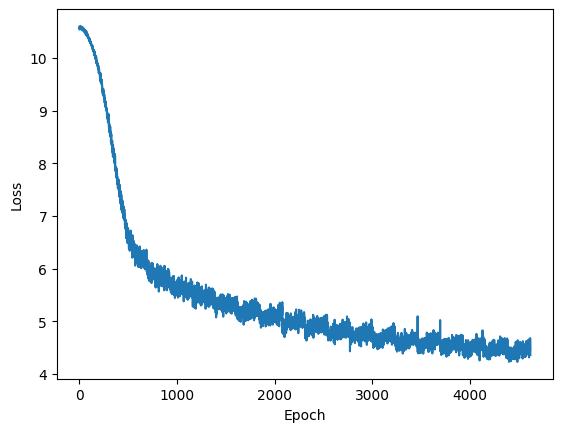

In [39]:
plt.plot(train_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

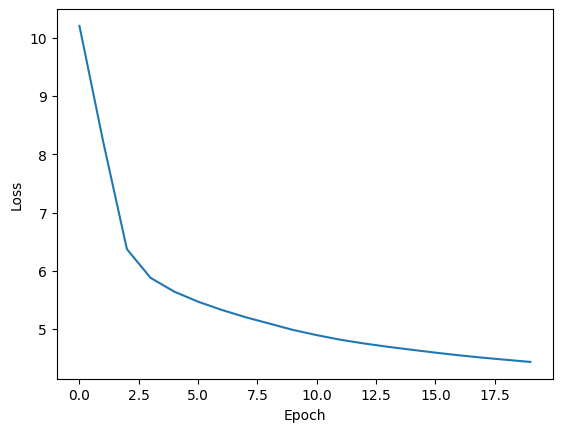

In [40]:
plt.plot(epoch_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')


<a name='13'></a>
# 13 - Summarize some Sentences!

Below you can see an example of summarization of a sentence from the training set and a sentence from the test set. See if you notice anything interesting about them!

In [41]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
print(summarize(transformer, document[training_set_example]))

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:
[SOS] tom and he will be late [EOS]


In [40]:
test_set_example = 3

# Check a summary of a document from the test set
print('Test set example:')
print(document_test[test_set_example])
print('\nHuman written summary:')
print(summary_test[test_set_example])
print('\nModel written summary:')
print(summarize(transformer, document_test[test_set_example]))

Test set example:
[SOS] will: hey babe, what do you want for dinner tonight?  emma:  gah, don't even worry about it tonight  will: what do you mean? everything ok?  emma: not really, but it's ok, don't worry about cooking though, i'm not hungry  will: well what time will you be home?  emma: soon, hopefully  will: you sure? maybe you want me to pick you up?  emma: no no it's alright. i'll be home soon, i'll tell you when i get home.   will: alright, love you.   emma: love you too.  [EOS]

Human written summary:
[SOS] emma will be home soon and she will let will know. [EOS]

Model written summary:
[SOS] it ' s place to the party [EOS]


If you critically examine the output of the model, you can notice a few things:
 - In the training set the model output is (almost) identical to the real output (already after 20 epochs and even more so with more epochs). This might be because the training set is relatively small and the model is relatively big and has thus learned the sentences in the training set by heart (overfitting).
 - While the performance on the training set looks amazing, it is not so good on the test set. The model overfits, but fails to generalize. Again an easy candidate to blame is the small training set and a comparatively large model, but there might be a variety of other factors.
 - Look at the test set example 3 and its summarization. Would you summarize it the same way as it is written here? Sometimes the data may be ambiguous. And the training of **your model can only be as good as your data**.

Here you only use a small dataset, to show that something can be learned in a reasonable amount of time in a relatively small environment. Generally, large transformers are trained on more than one task and on very large quantities of data to achieve superb performance. You will learn more about this in the rest of this course.

**Congratulations on finishing this week's assignment!** You did a lot of work and now you should have a better understanding of the Transformers and their building blocks (encoder and decoder) and how they can be used for text summarization. And remember: you dont need to change much to use the same model for a translator, just change the dataset and it should work!

**Keep it up!**